## Advanced ML: Домашнее задание 1
Галкин Дмитрий, студент MADE-DS-22

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

### Задание 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [2]:
df0 = pd.read_csv("owid-covid-data.csv")

In [3]:
# выберем Россию, записи с датой после 3 марта, столбцы "date", "total_cases" и "new_cases"
df = df0.loc[
    (df0.location == "Russia") & (df0.date >= "2020-03-03"), ["date", "total_cases", "new_cases"]
].reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

# замена нулей на единицы
df["new_cases"] = df["new_cases"].apply(lambda x: 1 if x == 0 else x)

# номер дня
df["day"] = np.arange(1, df.shape[0] + 1)

# разбиение на train / test
train = df.iloc[:50]
test = df.iloc[50:]

train.shape, test.shape

((50, 4), (678, 4))

In [4]:
train.head()

,date,total_cases,new_cases,day
0,2020-03-03,3.0,1.0,1
1,2020-03-04,3.0,1.0,2
2,2020-03-05,4.0,1.0,3
3,2020-03-06,13.0,9.0,4
4,2020-03-07,13.0,1.0,5


### Задание 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

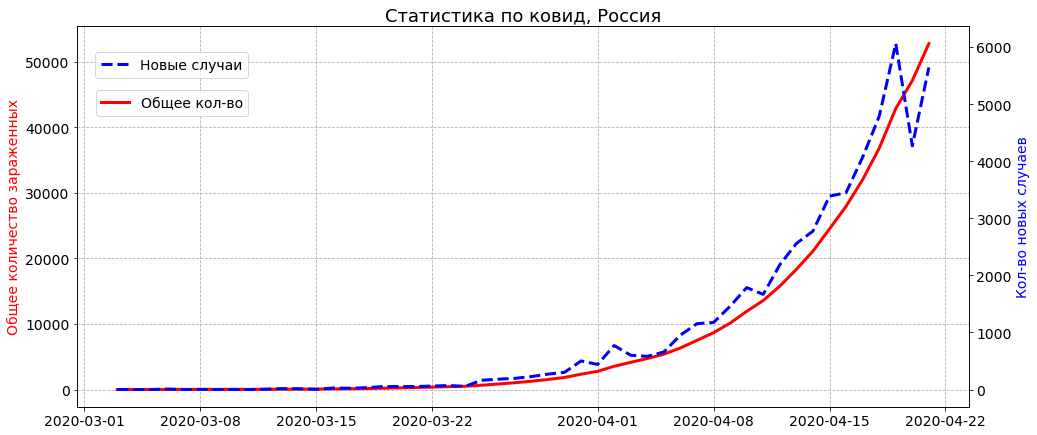

In [5]:
fig, ax1 = plt.subplots(figsize=(16, 7))

ax1.plot(train.date, train.total_cases, linewidth=3, color="red", linestyle="-", label="Общее кол-во")
ax2 = ax1.twinx()
ax2.plot(train.date, train.new_cases, color="blue", linewidth=3, linestyle="--", label="Новые случаи")

ax1.set_title("Статистика по ковид, Россия", fontsize=18)
ax1.set_ylabel("Общее количество зараженных", fontsize=14, color="red")
ax1.grid(linestyle="--")
ax1.legend(loc="best", bbox_to_anchor=(0.2, 0.85), fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.set_ylabel("Кол-во новых случаев", fontsize=14, color="blue")
ax2.legend(loc="best", bbox_to_anchor=(0.2, 0.95), fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.show()

### Задание 2а
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

> Для построения линейной регрессии с экспоненциальным ростом числа заболевших прологарифмируем целевую переменную. Получим модель следующего вида: ${log(y) = w_1 \cdot x + w_0}$. Т.е. будем предсказывать логарифм числа заболевших. 

In [6]:
def prediction(X_train, y_train, X_test):
    """Обучение лин.регрессии + предсказания на трейне и тесте."""
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    return model.predict(X_train), model.predict(X_test)
    

def plot_train_test_prediction(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred, title="", xlabel=""):
    """Построение графиков истинных и предсказанных значений на трейне и тесте."""
    
    plt.figure(figsize=(12, 7))
    
    plt.plot(X_train[:, 0], y_train, "*", markersize=10, label="train: real")
    plt.plot(X_train[:, 0], y_train_pred, linewidth=2, label="train: predict")
    plt.plot(X_test[:, 0], y_test, "*", markersize=10, label="test: real")
    plt.plot(X_test[:, 0], y_test_pred, linewidth=2, label="test: predict")
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.grid("--")
    plt.legend(fontsize=14); 

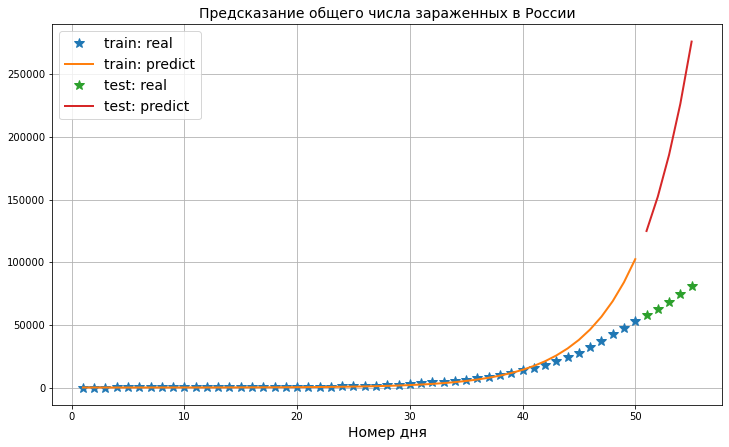

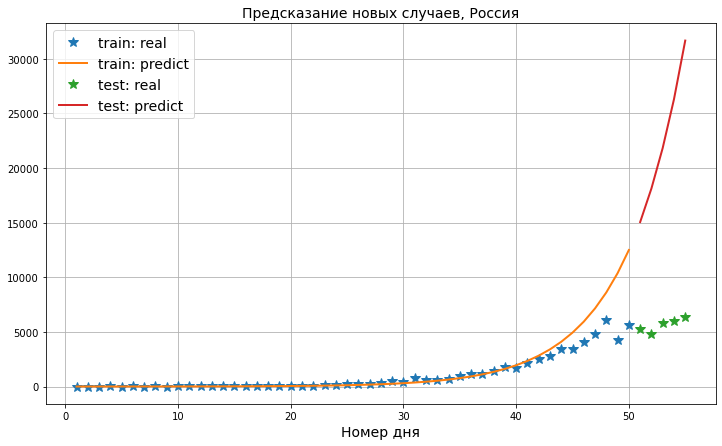

In [7]:
test_days = 5  # кол-во дней из тестовой выборки
X_train = train.day.values.reshape(-1, 1)
X_test = test.day.values[:test_days].reshape(-1, 1)

# общее кол-во
y_train_total = train.total_cases.values
y_test_total = test.total_cases[:test_days]

y_train_total_pred, y_test_total_pred = prediction(
    X_train, np.log(y_train_total), X_test
)
plot_train_test_prediction(
    X_train, y_train_total, np.exp(y_train_total_pred), 
    X_test, y_test_total, np.exp(y_test_total_pred), 
    title="Предсказание общего числа зараженных в России", 
    xlabel="Номер дня"
)

# новые случаи
y_train_new = train.new_cases.values
y_test_new = test.new_cases[:test_days]

y_train_new_pred, y_test_new_pred = prediction(
    X_train, np.log(y_train_new), X_test
)
plot_train_test_prediction(
    X_train, y_train_new, np.exp(y_train_new_pred), 
    X_test, y_test_new, np.exp(y_test_new_pred), 
    title="Предсказание новых случаев, Россия", 
    xlabel="Номер дня"
)

> **Промежуточный вывод:** 

> прогноз модели с экспоненциальным ростом числа заболевших растет существенно быстрее, чем реальное количество заболевших.

### Задание 2b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

> Т.к. графики *total_cases* и *new_cases* качественно похожи в плане динамики роста, и значения одной переменной можно получить из другой, то далее в данном пункте будем работать только с общим количеством зараженных (переменной *total_cases*)

In [8]:
def bayesian_update(mu0, sigma0, x, y, var_noise):
    
    x_m = np.hstack((np.ones((x.shape[0], 1)), x))
    
    sigma_n = np.linalg.inv(
        np.linalg.inv(sigma0) + (x_m.T @ x_m) / var_noise
    )
    mu_n = sigma_n @ (np.linalg.inv(sigma0) @ mu0.T + x_m.T @ y / var_noise)
    
    return mu_n, sigma_n


def get_var_noise(y_train, y_pred):
    # значение дисперсии шума в данных
    var_noise = (y_train - y_pred).var()
    return var_noise


def plot_heatmap(X, Y, Z):
    # Make the plot
    plt.figure(figsize=(10, 7))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title("Апостериорное распределение параметров модели ${log(y) = w_1 \cdot x + w_0}$", fontsize=14)
    plt.xlabel("Смещение, ${w_1}$", fontsize=14)
    plt.ylabel("Наклон, ${w_0}$", fontsize=14)

In [9]:
# значение дисперсии шума в данных
var_noise = get_var_noise(np.log(y_train_total), y_train_total_pred)

# мат.ожидание и дисперсия априорного распределения параметров модели
mu0 = np.array([0, 0])
sigma0 = np.diag([1, 1])

# обновление параметров
mu_n, sigma_n = bayesian_update(mu0, sigma0, X_train, np.log(y_train_total), var_noise)

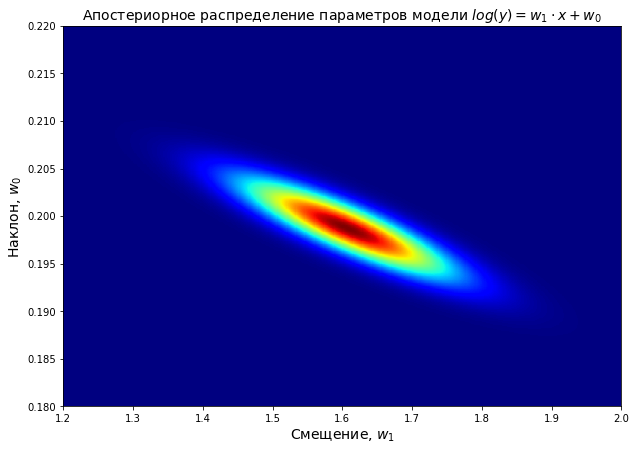

In [10]:
N = 500

X = np.linspace(1.2, 2, N)
Y = np.linspace(0.18, 0.22, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=mu_n, cov=sigma_n)

plot_heatmap(X, Y, Z)

### Задание 2c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [11]:
def plot_sample_exp(mu, sigma, x, y, n=20, title=""):
    
    # Посэмплируем экспоненты и нариусем графики
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    plt.figure(figsize=(15, 7))
    plt.plot(x, y, "*", markersize=10, label="Total cases actual")
    plt.grid(linestyle="--");
    plt.title(title, fontsize=14)
    plt.xlabel("Номер дня", fontsize=14)
    plt.grid("--")
    plt.legend(fontsize=14)
    
    for w in my_w:
        y_pred = np.exp(w[0] + w[1] * x)       
        plt.plot(x, y_pred)
        
        
def get_sample_prediction(mu, sigma, n, day_number):
    """Массив прогнозов кол-ва зараженных на номер дня = day_number"""
        
    w = np.random.multivariate_normal(mu, sigma, n)
    y = np.exp(w[:, 0] + w[:, 1] * day_number)
    
    return y
        
        
def get_mean_sample_prediction(mu, sigma, n, day_number):
    """Средний прогноз по результатам семплирования на номер дня = day_number."""
        
    w = np.random.multivariate_normal(mu, sigma, n)
    y_mean = np.exp(w[:, 0] + w[:, 1] * day_number).mean()
    
    return y_mean

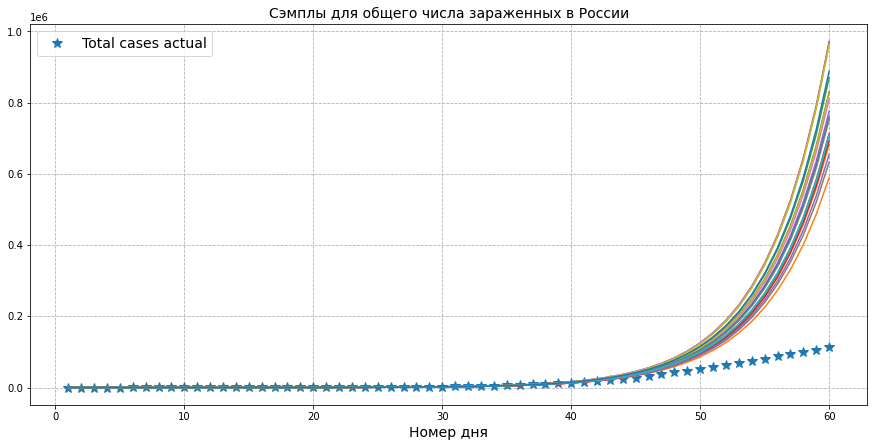

In [12]:
days_number = 60
x = df.day.iloc[:days_number]
y = df.total_cases.iloc[:days_number]
plot_sample_exp(mu_n, sigma_n, x, y, n=20, title="Сэмплы для общего числа зараженных в России")

In [14]:
dates = ["2020-05-01", "2020-06-01", "2020-09-01"]

print()
for date in dates:
    total_cases_pred_mean = get_mean_sample_prediction(
        mu_n, sigma_n, n=100, day_number=df.loc[df.date==date, "day"].iloc[0]
    )
    print(f"Общее количество случаев заражения. Прогноз на {date}: {round(total_cases_pred_mean)}")
print()


Общее количество случаев заражения. Прогноз на 2020-05-01: 754310
Общее количество случаев заражения. Прогноз на 2020-06-01: 372633549
Общее количество случаев заражения. Прогноз на 2020-09-01: 36192477337284192



> Как говорили на лекции, к 1 сентября 2020 уже заражен каждый атом на Земле:)

Построим предсказательное распределение

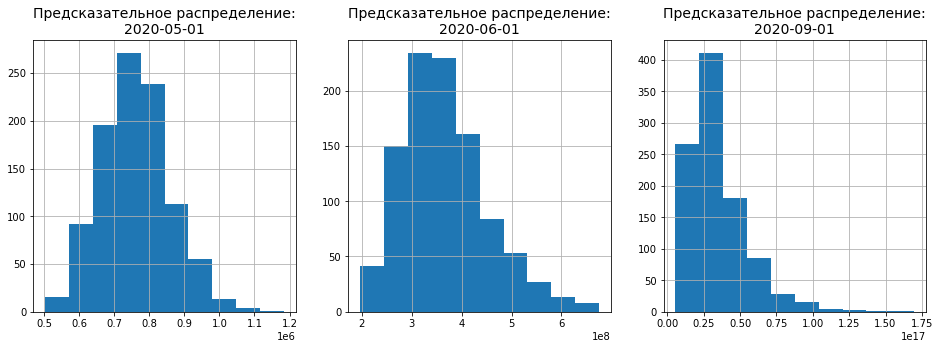

In [15]:
dates = ["2020-05-01", "2020-06-01", "2020-09-01"]

plt.figure(figsize=(16, 5))
for i, date in enumerate(dates):
    total_cases_pred = get_sample_prediction(
        mu_n, sigma_n, n=1000, day_number=df.loc[df.date==date, "day"].iloc[0]
    )
    plt.subplot(int(f"13{i + 1}"))
    plt.title(f"Предсказательное распределение:\n{date}", fontsize=14)
    plt.hist(total_cases_pred)
    plt.grid();

> Чем "дальше" дата, тем шире распределение. Т.е. получается уверенность в результатах становится меньше

**Промежуточные выводы по заданию 2:**

* Используя модель экспоненциального роста числа зараженных, была построена линейная регрессия. Для этого в качестве целевой переменной использовался логарифм числа зараженных. Предсказание данной модели растет существенно быстрее, чем реальное число зараженных. Что логично для экспоненты.
* Было найдено апостериорное распределение параметров этой модели, исходя из предположения о нормальном распределнии параметров модели и шума данных в качестве априорного распределения.
* Было просэмплировано несколько экспонент из этого распределения. Как понял, можно использовать гипотезы о линейной зависимости и нормальном распределении параметров модели и шума, найти апостериорное распределение на основе наших данных, и, собственно, никак не обучать линейную регрессию в обычном понимании. Просто можно сэмплировать параметры модели и получать +- такие же результаты. Модель линейной регрессии здесь использовали для оценки дисперсии шума в данных только.
* Были построены предсказательные распределения для трех дат. Получилось, что чем "дальше" дата, тем больше разброс значений. Т.е. уверенность в прогнозе также снижается.

### Задание 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана

### Задание 3a
Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

> Под интегралом в функции распределения Гауссиана стоит экспонента. А интеграл - это есть сумма. Поэтому мы можем построить модель вида **y~exp(полином 2-й степени от X)**, где в качестве целевой переменной будет использоваться переменная *new_cases*. А значение *total_cases* будет, соответственно, получаться суммированием предсказанных значений *new_cases*

> С точностью до констант модель плотности нормального распределения записывается следующим образом: ${y = w_0 \cdot e^{-(x - w_1)^2}}$. Прологарифмировав левую и правую части, получим: ${log(y) = w_2 x^2 + w_1 x + w_0}$ Т.е. мы опять пришли к линейной регрессии, где в качестве целевой переменной логарифм величины *new_cases*, а к признакам добавился квадрат номера дня.

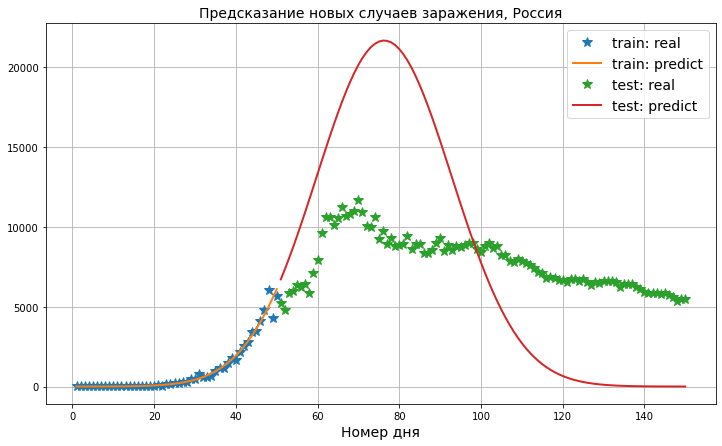

In [16]:
test_days = 100  # кол-во дней из тестовой выборки

X_train = train.day.values.reshape(-1, 1)
X_train = np.hstack((X_train, X_train**2))
X_test = test.day.values[:test_days].reshape(-1, 1)
X_test = np.hstack((X_test, X_test**2))

# новые случаи
y_train_new = train.new_cases.values
y_test_new = test.new_cases[:test_days]

y_train_new_pred, y_test_new_pred = prediction(
    X_train, np.log(y_train_new), X_test
)
plot_train_test_prediction(
    X_train, y_train_new, np.exp(y_train_new_pred), 
    X_test, y_test_new, np.exp(y_test_new_pred), 
    title="Предсказание новых случаев заражения, Россия", 
    xlabel="Номер дня"
)

> На графике выше виден "колокол". Плюс теперь предсказания не уходят бесконечно вверх, хотя тоже достаточно сильно отстоят от истинных значений.

Построим теперь график предсказания общего количества случаев, просуммировав прогноз по новым случаям.

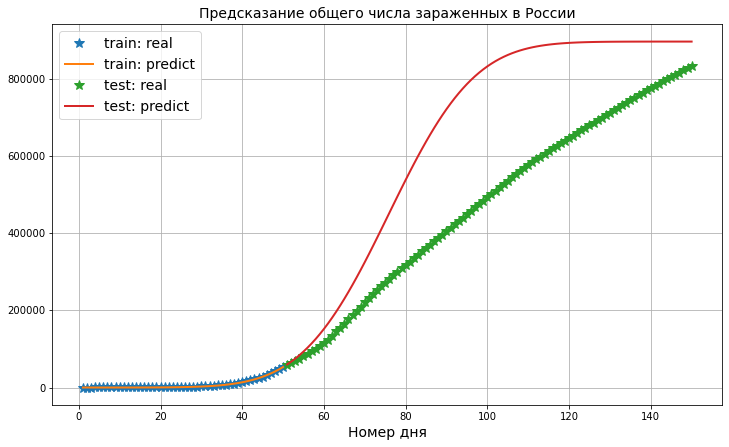

In [17]:
plot_train_test_prediction(
    X_train, train.total_cases.values, np.cumsum(np.exp(y_train_new_pred)), 
    X_test, test.total_cases[:test_days].values, np.cumsum(np.exp(y_test_new_pred)) + np.cumsum(np.exp(y_train_new_pred))[-1], 
    title="Предсказание общего числа зараженных в России", 
    xlabel="Номер дня"
)

> Вверху на графике наблюдается сигмоидальная форма. Но при этом, в части экстрополяции (прогноз > 50 дней) визуально все также не идеально.

### Задание 3b
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

> Поступим аналогично **п.2b**, учтя тот факт, что теперь параметров модели 3, а не 2.

In [18]:
# значение дисперсии шума в данных
var_noise = get_var_noise(np.log(y_train_new), y_train_new_pred)

# мат.ожидание и дисперсия априорного распределения параметров модели
mu0 = np.array([0, 0, 0])
sigma0 = np.diag([1, 1, 1])

# обновление параметров
mu_n, sigma_n = bayesian_update(mu0, sigma0, X_train, np.log(y_train_new), var_noise)

print("Апостериорное распределение параметров. Характеристики.")
print()
print("Вектор средних:")
print(mu_n)
print()
print("Ковариационная матрица:")
print(sigma_n)

Апостериорное распределение параметров. Характеристики.

Вектор средних:
[-0.6429853   0.27679809 -0.00178859]

Ковариационная матрица:
[[ 4.46128406e-02 -3.53279772e-03  5.82943886e-05]
 [-3.53279772e-03  3.68983203e-04 -6.82512164e-06]
 [ 5.82943886e-05 -6.82512164e-06  1.34498814e-07]]


### Задание 3с
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [19]:
def plot_sample_exp(mu, sigma, x, y, n=20, title=""):
    
    # Посэмплируем экспоненты и нариусем графики
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    plt.figure(figsize=(15, 7))
    plt.grid(linestyle="--");
    plt.title(title, fontsize=14)
    plt.xlabel("Номер дня", fontsize=14)
    plt.grid("--")
    
    for w in my_w:
        y_pred = np.cumsum(np.exp(w[0] + w[1] * x + w[2] * x**2))
        plt.plot(x, y_pred)
        
    plt.plot(x, y, "*", markersize=15, label="Total cases actual", color="yellow")
    plt.legend(fontsize=14)
        
        
def get_sample_prediction(mu, sigma, n, day_number):
    """Массив прогнозов кол-ва зараженных на номер дня = day_number"""
        
    my_w = np.random.multivariate_normal(mu, sigma, n)
    x = np.arange(1, day_number + 1)
    stat = []
    for w in my_w:
        y_pred = np.sum(np.exp(w[0] + w[1] * x + w[2] * x**2))
        stat.append(y_pred)
    
    return np.array(stat)

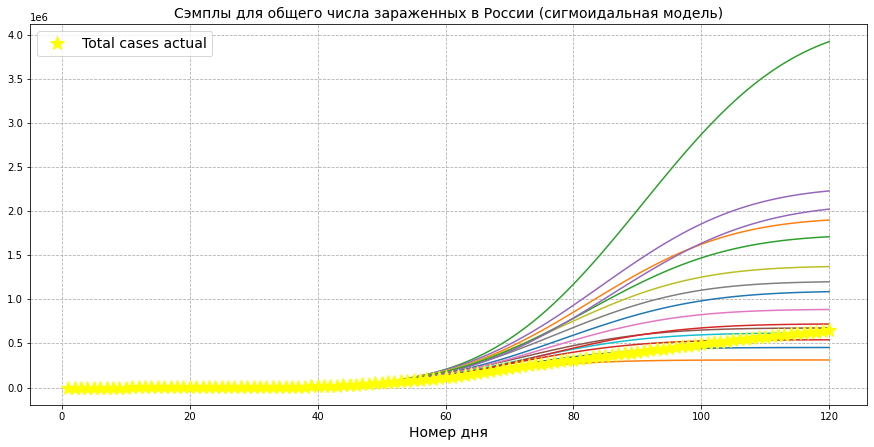

In [23]:
days_number = 120
x = df.day.iloc[:days_number]
y = df.total_cases.iloc[:days_number]
plot_sample_exp(mu_n, sigma_n, x, y, n=15, title="Сэмплы для общего числа зараженных в России (сигмоидальная модель)")

In [26]:
dates = ["2020-05-01", "2020-06-01", "2020-09-01"]

for date in dates:
    print(f"Общее количество случаев заражения. Прогноз на {date}:")
    total_cases_pred = get_sample_prediction(
        mu_n, sigma_n, n=5000, day_number=df.loc[df.date==date, "day"].iloc[0]
    )
    print(f"Прогноз медианный (50% процентиль):       {round(np.percentile(total_cases_pred, 50))}")
    print(f"Оптимистичный сценарий (10% процентиль):  {round(np.percentile(total_cases_pred, 10))}")
    print(f"Песcимистичный сценарий (90% процентиль): {round(np.percentile(total_cases_pred, 90))}")
    total_cases_real = round(df.loc[df.date==date, "total_cases"].iloc[0])
    print(f"Официальное число зараженных:\t\t  {total_cases_real}")
    print()

Общее количество случаев заражения. Прогноз на 2020-05-01:
Прогноз медианный (50% процентиль):       154667
Оптимистичный сценарий (10% процентиль):  114460
Песcимистичный сценарий (90% процентиль): 214010
Официальное число зараженных:		  114431

Общее количество случаев заражения. Прогноз на 2020-06-01:
Прогноз медианный (50% процентиль):       792851
Оптимистичный сценарий (10% процентиль):  326099
Песcимистичный сценарий (90% процентиль): 2615104
Официальное число зараженных:		  414328

Общее количество случаев заражения. Прогноз на 2020-09-01:
Прогноз медианный (50% процентиль):       991829
Оптимистичный сценарий (10% процентиль):  337198
Песcимистичный сценарий (90% процентиль): 5801977
Официальное число зараженных:		  997072



> Прогноз уже более оптимистичный с точки зрения того, что числа не стремятся к бесконечности. При этом во все эти дни реальное число зараженных лежит где-то между оптимистичным сценарием (10%) и медианным значениями (смещаясь все более вправо).

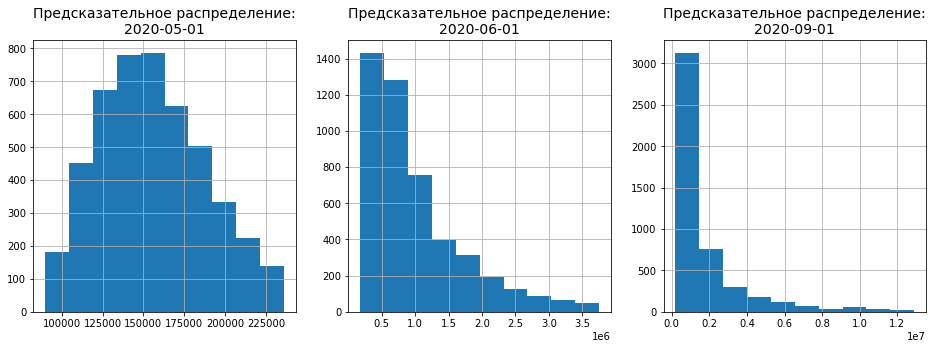

In [29]:
dates = ["2020-05-01", "2020-06-01", "2020-09-01"]

plt.figure(figsize=(16, 5))
for i, date in enumerate(dates):
    total_cases_pred = get_sample_prediction(
        mu_n, sigma_n, n=5000, day_number=df.loc[df.date==date, "day"].iloc[0]
    )
    plt.subplot(int(f"13{i + 1}"))
    plt.title(f"Предсказательное распределение:\n{date}", fontsize=14)
    plt.hist(total_cases_pred[
        (total_cases_pred > np.percentile(total_cases_pred, 1)) & (total_cases_pred <= np.percentile(total_cases_pred, 95))
    ])
    plt.grid();

> Ширина гистограмм стала Уже - значит разброс в предсказаниях уменьшился. Грубо увеличилась уверенность в ответе. Но все равно это плюс-минус несколько миллионов, что не мало. 

**Промежуточные выводы по заданию 3:**

* Используя модель сигмоиды для роста числа зараженных, была построена линейная регрессия. Для этого в качестве целевой переменной использовался логарифм прироста числа зараженных. В качестве признаков номер дня и квадрат номера дня. Предсказание данной модели сначала растет быстрее реального числа зараженных, затем выходит на плато. И реальное число зараженных становится больше прогноза со временем.
* Было найдено апостериорное распределение параметров этой модели, исходя из предположения о нормальном распределнии параметров модели и шума данных в качестве априорного распределения.
* Было просэмплировано несколько сигмоид из этого распределения. Оценены оптимистичные, пессимистичные и "в среднем" варианты развития событий для конкретных дат. Реальное число зараженных находится где-то между оптимистичным и медианным прогнозами. Что уже интересно. При этом чем дальше, тем больше прогноз отдаляется от оптимистичного сценария.
* Были построены предсказательные распределения для трех дат. Получилось, что ширина новых распределений Уже, чем у экспоненциальных моделей. А значит уверенность в прогнозе возрастает.

### Задание 4
Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

* Посмотрим на США, Италию, Испанию, Израиль, Бразилию и снова на Россию. При этом будем использовать только экспоненциальные модели. Найдем апостериорное распределение параметров. И визуально посмотрим, можно ли разделить страны на кластеры.

* Хотел еще на Китай посмотреть, но у него явно сигмоидальная модель за первые 2 месяца, поэтому некорректно было бы экспоненциальную модель применять.

In [30]:
# страны и примерные даты начала "постоянного" роста числа заболевших
countries_covid = {
    # "China": "2020-01-22", 
    "United States": "2020-01-22", 
    "Italy": "2020-02-20", 
    "Spain": "2020-02-24", 
    "Israel": "2020-02-26", 
    "Brazil": "2020-03-03", 
    "Russia": "2020-03-03"
}

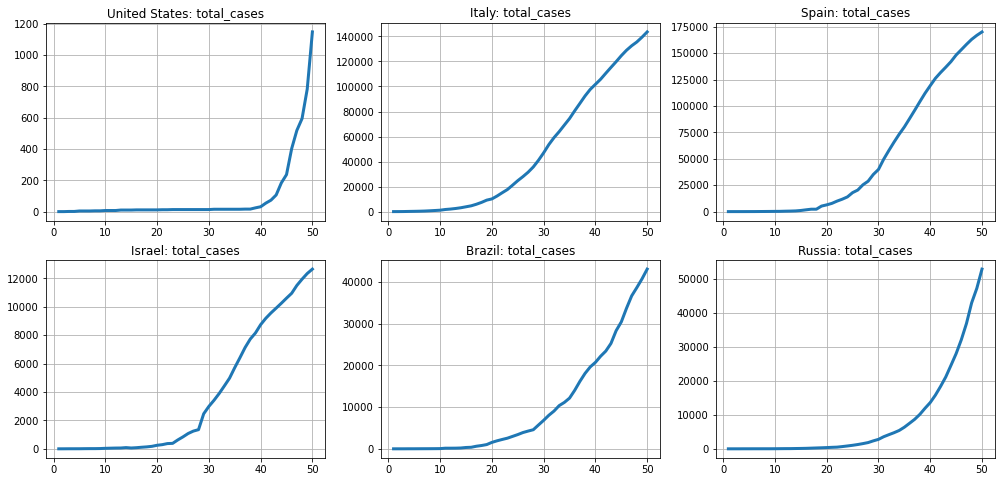

In [31]:
plt.figure(figsize=(17, 8))

i = 0
for country, date_start in countries_covid.items():
        
    df = df0.loc[
        (df0.location == country) & (df0.date >= date_start), ["date", "total_cases", ]
    ].reset_index(drop=True)
    df["date"] = pd.to_datetime(df["date"])
    df["day"] = np.arange(1, df.shape[0] + 1)
    train = df.iloc[:50]
    
    i += 1
    plt.subplot(f"23{i}")
    plt.plot(train.day, train.total_cases, linewidth=3, linestyle="-")
    plt.title(f"{country}: total_cases")
    plt.grid();

> У всех более-менее похожая форма поведения числа зараженных за первые 50 дней.

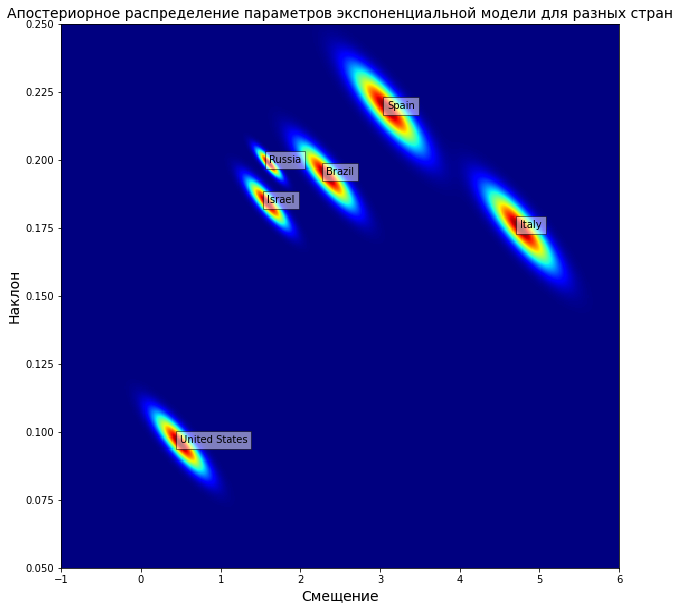

In [36]:
plt.figure(figsize=(10, 10))

N = 500
Z = np.zeros((N, N))

for country, date_start in countries_covid.items():
    
    df = df0.loc[
        (df0.location == country) & (df0.date >= date_start), ["date", "total_cases", ]
    ].reset_index(drop=True)
    df["date"] = pd.to_datetime(df["date"])

    # номер дня
    df["day"] = np.arange(1, df.shape[0] + 1)
    
    train = df.iloc[:50]
    test = df.loc[50:]  
    
    test_days = 5  # кол-во дней из тестовой выборки
    X_train = train.day.values.reshape(-1, 1)
    X_test = test.day.values[:test_days].reshape(-1, 1)

    # общее кол-во
    y_train_total = train.total_cases.values
    y_test_total = test.total_cases[:test_days]
    
    y_train_total_pred, y_test_total_pred = prediction(
        X_train, np.log(y_train_total), X_test
    )
    
    # значение дисперсии шума в данных
    var_noise = get_var_noise(np.log(y_train_total), y_train_total_pred)

    # мат.ожидание и дисперсия априорного распределения параметров модели
    mu0 = np.array([0, 0])
    sigma0 = np.diag([1, 1])

    # обновление параметров
    mu_n, sigma_n = bayesian_update(mu0, sigma0, X_train, np.log(y_train_total), var_noise)

    X = np.linspace(-1, 6, N)
    Y = np.linspace(0.05, 0.25, N)
    X, Y = np.meshgrid(X, Y)

    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    Z_new = multivariate_normal.pdf(pos, mean=mu_n, cov=sigma_n)
    Z += Z_new / Z_new.max()  # нормировка для визуализации

    plt.title("Апостериорное распределение параметров экспоненциальной модели для разных стран", fontsize=14)
    plt.xlabel("Смещение", fontsize=14)
    plt.ylabel("Наклон", fontsize=14)
    plt.text(mu_n[0], mu_n[1], country, bbox=dict(facecolor='white', alpha=0.5))
    
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet);

> Визуально очень хорошо можно разделить данные страны по апостериорному распределению параметров экспоненциальной модели - это значит, что у данных стран динамика начального этапа заражения населения происходила по разному. У России область параметров минимальна. Вероятно, это связано с тем, что лучше всех экспоненциальная модель в первые дни апроксимирует реальные данные.

### Задание 5
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?

* От себя скажу, что ДЗ вдохновило. Оно заставило пересмотреть несколько раз первые лекции, чтобы осознать, что надо делать. И ощущение того, что вначале прочитал ДЗ и ничего не понял, а спустя какое-то время что-то понимаю и даже что-то сделал - прекрасное ощущение:) Если, конечно, правильно сделал ДЗ.

И по существу, что понял:
* Экстраполяция - вещь сомнительная
* Если правильно понимаю, то в нашем случае, если мы предполагаем линейную зависимость, нормальность распределения параметров модели и шума данных, то можно линейную регрессию не обучать. Получить параметры апостериорного распределения, сэмплировать из него уже веса и предсказывать ответ.
* Важно также понимать форму того, к чему все стремимся, и можно ли как-то к линейной регрессии перейти. В задании 3 при использовании сигмоидальной модели не сразу осознание пришло, как это сделать.
* Ну и по поводу ввода карантина: не знаю:) Вероятно, полученные числа должны анализировать компетентные люди с точки зрения наличия койко-мест в больницах и т.д. Но сигмоидальная модель дала предсказания количества зараженных на выбранные даты в 2020 году, которые неплохо совпадают с реальностью. Хоть и разброс большой, но реальные данные попали в предсказанный диапазон. Если постоянно пополнять обучающую выборку данными, то, возможно, релевантность прогноза сохранится. Но надо проверять. 